## Exploratory analysis of the MM-WHS dataset

In [6]:
# imports 
import numpy as np
import re
import os
import monai
from monai.data import CacheDataset, DataLoader, GridPatchDataset
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    RandRotate90d,
    Resized,
    ScaleIntensityd,
    SqueezeDimd,
)
from scipy import ndimage
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import torch

# Example CT dataset

In [9]:
data_dir = "../MMWHS_Dataset/ct_train"
images = sorted(glob.glob(os.path.join(data_dir, "ct_train_1001_image.nii.gz")))
labels = sorted(glob.glob(os.path.join(data_dir, "ct_train_1001_label.nii.gz")))

example_dataset = [{"img": img, "seg": seg} for img, seg in zip(images, labels)]

In [10]:
volume_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        ScaleIntensityd(keys="img"),
        EnsureTyped(keys=["img", "seg"]),
    ]
)

In [11]:
volume_ds_person1 = CacheDataset(data=example_dataset, transform=volume_transforms, cache_rate=1.0, num_workers=4) # experiment with last two parameters
check_loader = DataLoader(volume_ds_person1, batch_size=1)
check_data = monai.utils.misc.first(check_loader)

Loading dataset: 100%|██████████| 1/1 [01:05<00:00, 65.58s/it]


first volume's shape torch.Size([1, 1, 512, 512, 363]) torch.Size([1, 1, 512, 512, 363])


In [16]:
print("first volume's shape", check_data["img"].shape, check_data["seg"].shape)

middle_image = check_data["img"][0, :, :, :, 170]
middle_label = check_data["seg"][0, :, :, :, 170]
print("image shape", middle_image.shape, "label shape", middle_label.shape)

first volume's shape torch.Size([1, 1, 512, 512, 363]) torch.Size([1, 1, 512, 512, 363])
image shape torch.Size([1, 512, 512]) label shape torch.Size([1, 512, 512])


In [21]:
patch_func = monai.data.PatchIterd(
    keys=["img", "seg"],
    patch_size=(None, None, 1),  # dynamic first two dimensions
    start_pos=(0, 0, 0)
)
patch_transform = Compose(
    [
        SqueezeDimd(keys=["img", "seg"], dim=-1),  # squeeze the last dim
        Resized(keys=["img", "seg"], spatial_size=[224, 224]),
        # to use crop/pad instead of reszie:
        # ResizeWithPadOrCropd(keys=["img", "seg"], spatial_size=[48, 48], mode="replicate"),
    ]
)

example_patch_ds = GridPatchDataset(data=volume_ds_person1, patch_iter=patch_func, transform=patch_transform)
patch_data_loader = DataLoader(example_patch_ds, batch_size=5, num_workers=2, pin_memory=torch.cuda.is_available())

check_data_patch = monai.utils.misc.first(patch_data_loader)[0]

first image shape torch.Size([5, 1, 224, 224]) torch.Size([5, 1, 224, 224])


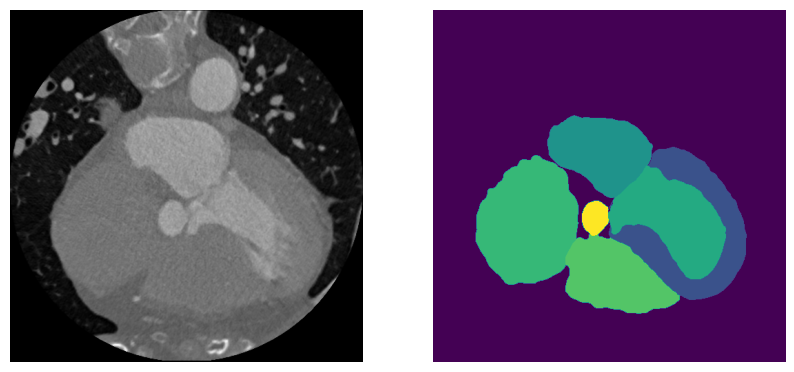

In [28]:
print("first image shape", check_data_patch["img"].shape, check_data_patch["seg"].shape)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(middle_image.T, cmap="gray")
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(middle_label.T)


In [44]:
print(middle_label[0, 250:350, 250:350])

metatensor([[420., 420., 420., 420., 420., 420., 420., 420., 420., 420., 420., 420.,
         420., 420., 420., 420., 420., 420., 420., 420., 420.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 820.,
         820., 820., 820., 820., 820., 820., 820., 820., 820., 820., 820., 820.,
         820., 820., 820., 820., 820., 820., 820., 820., 820., 820., 820., 820.,
         820., 820., 820., 820., 820.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 600., 600.,
         600., 600., 600., 600., 600., 600., 600., 600., 600., 600., 600., 600.,
         600., 600., 600., 600.],
        [420., 420., 420., 420., 420., 420., 420., 420., 420., 420., 420., 420.,
         420., 420., 420., 420., 420., 420., 420., 420., 420., 420.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         820., 820., 820., 820., 820., 820., 820., 820., 820., 820., 82